# Pipeline Refactor Testing

In [1]:
import astropy.units as u
import numpy as np
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import get_horizons_coord, Helioprojective
import asdf
import xarray

from mocksipipeline.physics.spectral import SpectralModel

import sys
import glob
sys.path.append('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/workflow/scripts/')
from calculate_dem import build_map_collection, calculate_response_kernels, compute_em

In [7]:
all_maps = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_2') + sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/uncertainty')

In [8]:
collection = build_map_collection(all_maps)

In [9]:
spectral_table = SpectralModel().spectral_table

In [14]:
temperature_bin_edges = 10**np.arange(5.5,7.5+0.1,0.1) * u.K
temperature_kernel = 10**np.arange(5, 8, 0.05) * u.K
kernels = calculate_response_kernels(collection,
                                     temperature_kernel,
                                     spectral_table)

In [15]:
em_cube = compute_em(collection,
                     kernels,
                     temperature_bin_edges,
                     temperature_kernel)

100%|█████████████████████████████████████████████████████████████████| 1.14k/1.14k [01:34<00:00, 12.0 x10^2 DEM/s]


Now, figure out how to serialize the EM cube

In [19]:
em_cube.wcs

CompoundLowLevelWCS Transformation

This transformation has 3 pixel and 3 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None
        2  None            None  None

World Dim  Axis Name    Physical Type                   Units
        0  None         custom:pos.helioprojective.lon  deg
        1  None         custom:pos.helioprojective.lat  deg
        2  temperature  phys.temperature                K

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes  yes   no
        1  yes  yes   no
        2   no   no  yes

In [21]:
em_cube.data.shape

(20, 338, 338)

In [24]:
em_cube.axis_world_coords(0)[0].to_value('K')

array([  354813.38923358,   446683.59215096,   562341.32519035,
         707945.78438414,   891250.93813374,  1122018.45430196,
        1412537.54462275,  1778279.41003891,  2238721.13856832,
        2818382.93126443,  3548133.89233572,  4466835.92150959,
        5623413.25190343,  7079457.8438413 ,  8912509.38133735,
       11220184.54301949, 14125375.44622735, 17782794.10038897,
       22387211.38568306, 28183829.31264409])

In [39]:
dict(all_maps[0].wcs.to_header())

{'WCSAXES': 2,
 'CRPIX1': 169.5,
 'CRPIX2': 169.5,
 'CDELT1': 0.0020555555555556,
 'CDELT2': 0.0020555555555556,
 'CUNIT1': 'deg',
 'CUNIT2': 'deg',
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'LONPOLE': 180.0,
 'LATPOLE': 0.0,
 'MJDREF': 0.0,
 'DATE-OBS': '2020-11-09T17:59:57.000',
 'MJD-OBS': 59162.749965278,
 'RSUN_REF': 695700000.0,
 'DSUN_OBS': 148154617580.44,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 3.4233547396973}

In [42]:
em_cube.unit.to_string()

'1 / cm5'

In [46]:
xarray.Variable('temperature', em_cube.axis_world_coords(0)[0].to_value('K'), attrs={'unit': 'K'})

<xarray.Variable (temperature: 20)>
array([  354813.38923358,   446683.59215096,   562341.32519035,
         707945.78438414,   891250.93813374,  1122018.45430196,
        1412537.54462275,  1778279.41003891,  2238721.13856832,
        2818382.93126443,  3548133.89233572,  4466835.92150959,
        5623413.25190343,  7079457.8438413 ,  8912509.38133735,
       11220184.54301949, 14125375.44622735, 17782794.10038897,
       22387211.38568306, 28183829.31264409])
Attributes:
    unit:     K

In [51]:
wcs_keys = dict(all_maps[0].wcs.to_header())
temperature_coord = xarray.Variable('temperature', em_cube.axis_world_coords(0)[0].to_value('K'), attrs={'unit': 'K'})
em_array = xarray.DataArray(
    em_cube.data,
    dims=['temperature', 'lat', 'lon'],
    coords={
        'temperature': temperature_coord,
    },
    attrs={**wcs_keys, 'unit': em_cube.unit.to_string()}
)

In [55]:
from matplotlib.colors import LogNorm

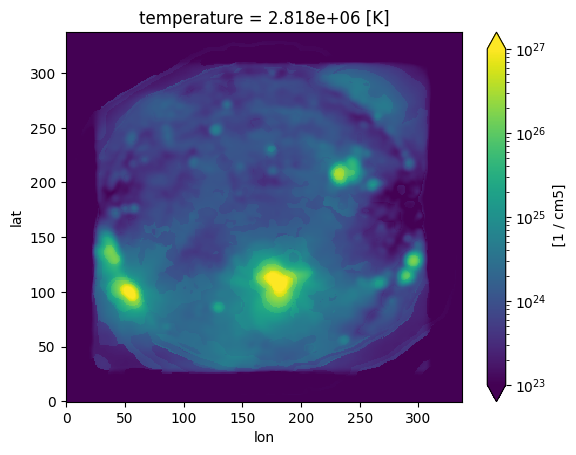

In [61]:
em_array[9,...].plot.imshow(norm=LogNorm(vmin=1e23, vmax=1e27))

In [62]:
em_array.to_netcdf('em_array.nc')

In [65]:
em_array_from_disk = xarray.open_dataarray('em_array.nc')

In [66]:
em_array_from_disk

<xarray.DataArray (temperature: 20, lat: 338, lon: 338)>
[2284880 values with dtype=float64]
Coordinates:
  * temperature  (temperature) float64 3.548e+05 4.467e+05 ... 2.818e+07
Dimensions without coordinates: lat, lon
Attributes:
    WCSAXES:   2
    CRPIX1:    169.5
    CRPIX2:    169.5
    CDELT1:    0.0020555555555556
    CDELT2:    0.0020555555555556
    CUNIT1:    deg
    CUNIT2:    deg
    CTYPE1:    HPLN-TAN
    CTYPE2:    HPLT-TAN
    CRVAL1:    0.0
    CRVAL2:    0.0
    LONPOLE:   180.0
    LATPOLE:   0.0
    MJDREF:    0.0
    DATE-OBS:  2020-11-09T17:59:57.000
    MJD-OBS:   59162.749965278
    RSUN_REF:  695700000.0
    DSUN_OBS:  148154617580.44
    HGLN_OBS:  0.0
    HGLT_OBS:  3.4233547396973
    unit:      1 / cm5

In [70]:
em_cube.wcs

CompoundLowLevelWCS Transformation

This transformation has 3 pixel and 3 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None
        2  None            None  None

World Dim  Axis Name    Physical Type                   Units
        0  None         custom:pos.helioprojective.lon  deg
        1  None         custom:pos.helioprojective.lat  deg
        2  temperature  phys.temperature                K

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes  yes   no
        1  yes  yes   no
        2   no   no  yes

In [69]:
u.Quantity(em_array_from_disk.temperature.data, em_array_from_disk.temperature.attrs['unit'])

<Quantity [  354813.38923358,   446683.59215096,   562341.32519035,
             707945.78438414,   891250.93813374,  1122018.45430196,
            1412537.54462275,  1778279.41003891,  2238721.13856832,
            2818382.93126443,  3548133.89233572,  4466835.92150959,
            5623413.25190343,  7079457.8438413 ,  8912509.38133735,
           11220184.54301949, 14125375.44622735, 17782794.10038897,
           22387211.38568306, 28183829.31264409] K>

In [81]:
em_array['temperature']

<xarray.DataArray 'temperature' (temperature: 20)>
array([  354813.389234,   446683.592151,   562341.32519 ,   707945.784384,
         891250.938134,  1122018.454302,  1412537.544623,  1778279.410039,
        2238721.138568,  2818382.931264,  3548133.892336,  4466835.92151 ,
        5623413.251903,  7079457.843841,  8912509.381337, 11220184.543019,
       14125375.446227, 17782794.100389, 22387211.385683, 28183829.312644])
Coordinates:
  * temperature  (temperature) float64 3.548e+05 4.467e+05 ... 2.818e+07
Attributes:
    unit:     K

In [84]:
from synthesizAR.instruments.util import extend_celestial_wcs
import ndcube


def read_cube_with_xarray(filename, axis_name, physical_type):
    """
    Read an xarray netCDF file and rebuild an NDCube

    This function reads a data cube from a netCDF file and rebuilds it
    as an NDCube. The assumption is that the attributes on the stored
    data array have the keys necessary to reconstitute a celestial FITS
    WCS and that the axis denoted by `axis_name` is the additional axis
    along which to extend that celestial WCS. This works only for 3D cubes
    where two of the axes correspond to spatial, celestial axes.

    Parameters
    ----------
    filename: `str`, path-like
        File to read from, usually a netCDF file
    axis_name: `str`
        The addeded coordinate along which to extend the celestial WCS.
    physical_type: `str`
        The physical type of `axis_name` as denoted by the IVOA designation.
    """
    cube_xa = xarray.open_dataarray(filename)
    # Make quantity
    meta = cube_xa.attrs
    data = u.Quantity(cube_xa.data, meta.pop('unit'))
    # Build celestial WCS from attributes
    celestial_wcs = astropy.wcs.WCS(header=meta)
    # Get temperature axis
    axis_array = u.Quantity(cube_xa[axis_name].data, cube_xa[axis_name].attrs.get('unit'))
    # Build combined WCS with temperature axis
    combined_wcs = extend_celestial_wcs(celestial_wcs, axis_array, axis_name, physical_type)
    # Build NDCube
    return ndcube.NDCube(data, wcs=combined_wcs)


def write_cube_with_xarray(cube, axis_name, celestial_wcs, filename):
    """
    Write an NDCube to a netCDF file

    This function writes an NDCube to a netCDF file by first expressing 
    it as an xarray DataArray. This works only for 3D cubes where two of
    the axes correspond to spatial, celestial axes.

    Parameters
    ----------
    cube: `ndcube.NDCube`
    axis_name: `str`
    celestial_wcs: `astropy.wcs.WCS`
    filename: `str` or path-like
    """
    wcs_keys = dict(celestial_wcs.to_header())
    axis_array = cube.axis_world_coords(axis_name)[0]
    axis_coord = xarray.Variable(axis_name, axis_array.value, attrs={'unit': axis_array.unit.to_string()})
    cube_xa = xarray.DataArray(
        cube.data,
        dims=[axis_name, 'lat', 'lon'],
        coords={
            axis_name: axis_coord,
        },
        attrs={**wcs_keys, 'unit': cube.unit.to_string()}
    )
    cube_xa.to_netcdf(filename)


In [85]:
write_cube_with_xarray(em_cube, 'temperature', all_maps[0].wcs, 'em_cube.nc')

In [86]:
em_cube_from_disk = read_cube_with_xarray('em_cube.nc', 'temperature', 'phys.temperature')

<WCSAxesSubplot:>

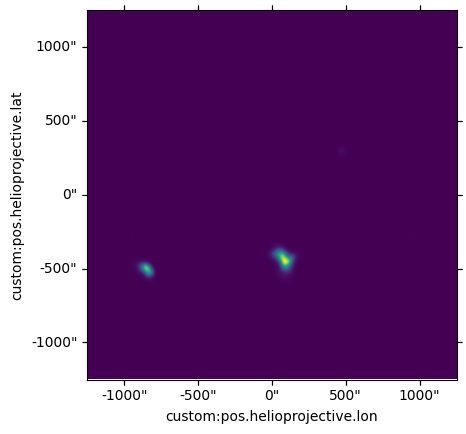

In [90]:
em_cube_from_disk[15,...].plot()

<WCSAxesSubplot:>

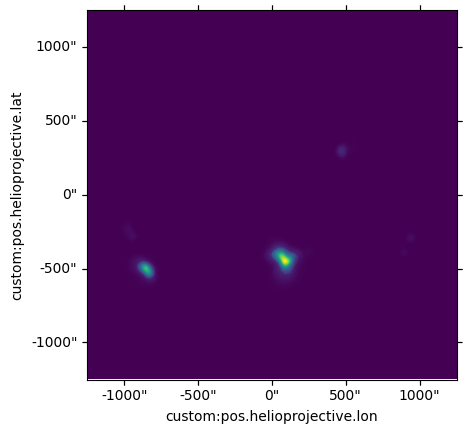

In [88]:
em_cube[10,...].plot()

## Sandbox

In [4]:

new_frame = Helioprojective(observer=get_horizons_coord('SDO', time=smap.date), obstime=smap.date)
#with asdf.AsdfFile({'frame': new_frame}) as af:
#    af.write_to('common-frame.asdf')

NameError: name 'smap' is not defined

In [57]:
with asdf.open('common-frame.asdf') as af:
    new_frame_from_disk = af.tree['frame']

In [58]:
new_frame_from_disk

<Helioprojective Frame (obstime=2020-11-09T17:59:57.340, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2020-11-09T17:59:57.340, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0.00600811, 3.43380665, 0.99016256)>)>

In [ ]:
sm._

In [6]:
smap = sunpy.map.Map('../pipeline-runs/ar-test/AIA/aia_lev1_171a_2020_11_09t17_59_57_34z_image_lev1.fits')

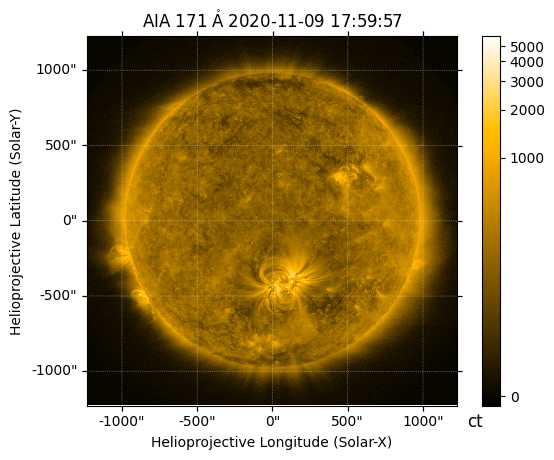

In [7]:
smap.peek()

In [9]:
smap.date.isot

'2020-11-09T17:59:57.340'

In [67]:
smap.meta['measrmnt']

KeyError: 'measrmnt'

In [17]:
import aiapy.calibrate.util
import astropy.units as u
import astropy.table

In [13]:
pt = aiapy.calibrate.util.get_pointing_table(smap.date-6*u.h, smap.date+6*u.h)

In [36]:
pt.meta.clear()

In [37]:
pt.write('pointing-table.asdf')

In [38]:
pt_from_disk = astropy.table.QTable.read('pointing-table.asdf')

In [41]:
all(pt_from_disk == pt)

True

In [42]:
cor_table = aiapy.calibrate.util.get_correction_table()

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [45]:
cor_table.meta.clear()
cor_table.write('correction-table.asdf')

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 100 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [46]:
cor_table_from_disk = astropy.table.QTable.read('correction-table.asdf')

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [48]:
all(cor_table == cor_table_from_disk)

True

In [35]:
pt.meta

OrderedDict([('__attributes__',
              {'client': <sunpy.net.jsoc.jsoc.JSOCClient object at 0x2818faa30>
               sunpy.net.jsoc.jsoc.JSOCClient
               
               Provides access to the JSOC Data Export service.
               Attr Type       Name                   Description             
               --------- ---------------- ------------------------------------
               Series    aia.flatfield    AIA flatfield                       
               Series    aia.lev1         AIA Level 1                         
               Series    aia.lev1_euv_12s AIA Level 1, 12 second cadence      
               Series    aia.lev1_uv_24s  AIA Level 1, 24 second cadence      
               Series    aia.lev1_vis_1h  AIA Level 1, 3600 second cadence    
               ...       ...              ...                                 
               Segment   vx               zonal velocity component            
               Segment   vy               0.0      

In [34]:
for c in pt.colnames:
    print(c)
    try:
        print(pt[c].dtype)
    except AttributeError:
        print(type(pt[c]))

ORIGIN
<U12
TELESCOP
<U3
DATE
<U20
T_START
<class 'astropy.time.core.Time'>
T_STOP
<class 'astropy.time.core.Time'>
T_HKVALS
<U20
VERSION
int64
SC_Y_INRT_BIAS
float64
SC_Z_INRT_BIAS
float64
H_CAM1_IMSCALE
float64
H_CAM1_X0
float64
H_CAM1_Y0
float64
H_CAM1_INSTROT
float64
H_CAM2_IMSCALE
float64
H_CAM2_X0
float64
H_CAM2_Y0
float64
H_CAM2_INSTROT
float64
A_094_IMSCALE
float64
A_094_X0
float64
A_094_Y0
float64
A_094_INSTROT
float64
A_131_IMSCALE
float64
A_131_X0
float64
A_131_Y0
float64
A_131_INSTROT
float64
A_171_IMSCALE
float64
A_171_X0
float64
A_171_Y0
float64
A_171_INSTROT
float64
A_193_IMSCALE
float64
A_193_X0
float64
A_193_Y0
float64
A_193_INSTROT
float64
A_211_IMSCALE
float64
A_211_X0
float64
A_211_Y0
float64
A_211_INSTROT
float64
A_304_IMSCALE
float64
A_304_X0
float64
A_304_Y0
float64
A_304_INSTROT
float64
A_335_IMSCALE
float64
A_335_X0
float64
A_335_Y0
float64
A_335_INSTROT
float64
A_1600_IMSCALE
float64
A_1600_X0
float64
A_1600_Y0
float64
A_1600_INSTROT
float64
A_1700_IMSCALE
flo

In [64]:
import numpy as np
(20*u.percent * np.ones(5) * u.DN).to_value('DN')

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [5]:
import astropy.time
from sunpy.coordinates import get_horizons_coord, Helioprojective, get_earth
obstime = astropy.time.Time('2020-11-09T17:59:57')
observer = get_earth(obstime)

In [6]:
observer

<SkyCoord (HeliographicStonyhurst: obstime=2020-11-09T17:59:57.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0., 3.42335474, 0.99035245)>

In [7]:
import sunpy.map

In [26]:
foo = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_2/aia_94.fits')

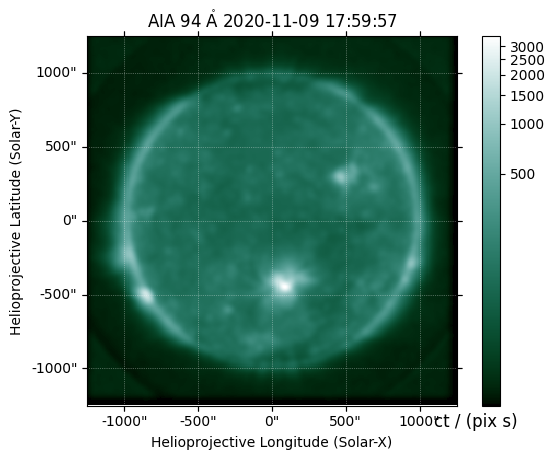

In [28]:
foo.peek()

In [16]:
foo.detector

'AIA'

In [29]:
bar = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_1/aia_94.fits')

In [37]:
import numpy as np

In [39]:
np.round((foo.scale.axis1 * foo.scale.axis2 / (bar.scale.axis1*bar.scale.axis2)).decompose()).value

152.0

In [33]:
bar.dimensions.x * bar.dimensions.y / (foo.dimensions.x*foo.dimensions.y)

<Quantity 146.8542418>

In [23]:
fooxrt = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_1/xrt_Be-thin:Open.fits')

In [25]:
fooxrt.meta

MetaDict([('simple', True),
          ('bitpix', -32),
          ('naxis', 2),
          ('naxis1', 1024),
          ('naxis2', 1024),
          ('date', '2020-11-18T10:11:58.000'),
          ('date_rf0', '2020-11-18T10:11:58.000'),
          ('date_rf1', '2020-11-22T12:39:08.256'),
          ('satellit', 33),
          ('telescop', 'HINODE'),
          ('instrume', 'XRT'),
          ('timesys', 'UTC (TBR)'),
          ('mdp_clk', 763908081),
          ('fileorig', '2020_1118_101003.sci'),
          ('p1row', 0),
          ('p2row', 2047),
          ('p1col', 0),
          ('rpos_col', 0),
          ('p2col', 2047),
          ('tr_mode', 'FIX'),
          ('img_mode', 1),
          ('aec_flg', 'off'),
          ('aec_tnum', 0),
          ('aec_rslt', 3),
          ('origin', 'JAXA/ISAS, SIRIUS'),
          ('data_lev', 2),
          ('orig_rf0', 'JAXA/ISAS, SIRIUS'),
          ('ver_rf0', '1.72'),
          ('orig_rf1', ''),
          ('ver_rf1', 'v2015-Aug-26'),
          ('prog_ver',

In [43]:
m_error = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/uncertainty/aia_94.fits')

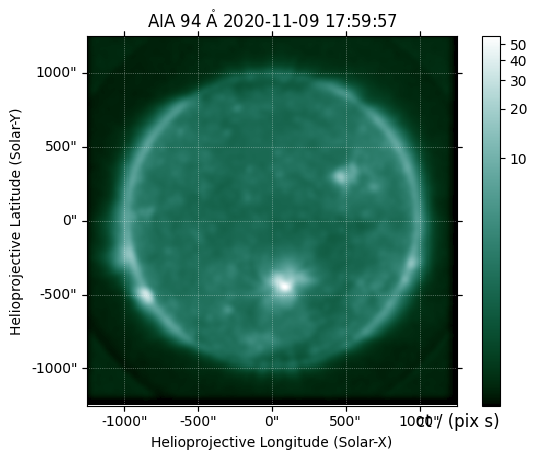

In [44]:
m_error.peek()

In [45]:
m_error.meta

MetaDict([('simple', True),
          ('bitpix', -64),
          ('naxis', 2),
          ('naxis1', 338),
          ('naxis2', 338),
          ('wcsaxes', 2),
          ('crpix1', 169.5),
          ('crpix2', 169.5),
          ('cdelt1', 7.4),
          ('cdelt2', 7.4),
          ('cunit1', 'arcsec'),
          ('cunit2', 'arcsec'),
          ('ctype1', 'HPLN-TAN'),
          ('ctype2', 'HPLT-TAN'),
          ('crval1', 0.0),
          ('crval2', 0.0),
          ('lonpole', 180.0),
          ('latpole', 0.0),
          ('mjdref', 0.0),
          ('date-obs', '2020-11-09T17:59:57.000'),
          ('rsun_ref', 695700000.0),
          ('dsun_obs', 148154617580.44),
          ('hgln_obs', 0.0),
          ('hglt_obs', 3.4233547396973),
          ('instrume', 'AIA 4'),
          ('telescop', 'SDO/AIA'),
          ('obsrvtry', 'SDO'),
          ('wavelnth', 94.0),
          ('waveunit', 'angstrom'),
          ('exptime', 2.900829),
          ('bunit', 'count pix-1 s-1'),
          ('pc1_1', 1

In [48]:
m_error.meta.get('measrmnt')

'uncertainty'

In [49]:
m_error.measurement

<Quantity 94. Angstrom>

In [50]:
foo.instrument

'AIA 4'

In [51]:
fooxrt.instrument

'XRT'

In [55]:
import astropy.units as u
(94*u.AA).to('eV', u.equivalencies.spectral())

<Quantity 131.89808344 eV>

In [56]:
from mocksipipeline.physics.spectral import SpectralModel

In [57]:
st = SpectralModel().spectral_table

In [59]:
import asdf

In [62]:
st.data

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.94400608e-17, 2.94196001e-17, 2.94161833e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.34352481e-17, 2.34027110e-17, 2.34005841e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.87253584e-17, 1.86651910e-17, 1.86643970e-17],
       ...,
       [1.30192041e-24, 1.29455967e-21, 3.26411432e-20, ...,
        1.03956558e-18, 1.03951217e-18, 1.03937289e-18],
       [1.11129821e-23, 5.05658033e-21, 8.80002497e-20, ...,
        1.00094470e-18, 1.00088313e-18, 1.00075859e-18],
       [7.44448316e-23, 1.68941170e-20, 2.11558224e-19, ...,
        9.63480909e-19, 9.63414239e-19, 9.63301219e-19]])

In [63]:
st.meta

{'ioneq_filename': 'chianti.ioneq',
 'abundance_filename': 'sun_coronal_1992_feldman_ext.abund',
 'ion_list': 'all',
 'version': '10.0.2',
 'include_continuum': True}

In [76]:
with asdf.AsdfFile({'gwcs': st.wcs, 'data': st.data, 'unit': st.unit, 'meta': st.meta}) as af:
    af.write_to('spec_table.asdf')

In [94]:
type(st.wcs)

gwcs.wcs.WCS

In [65]:
import ndcube

In [78]:
with asdf.open('spec_table.asdf') as af:
    st_from_disk = ndcube.NDCube(af['data'][:], wcs=af['gwcs'], unit=af['unit'], meta=af['meta'])

In [80]:
st_from_disk.meta

{'abundance_filename': 'sun_coronal_1992_feldman_ext.abund',
 'include_continuum': True,
 'ion_list': 'all',
 'ioneq_filename': 'chianti.ioneq',
 'version': '10.0.2'}

In [89]:
from sunpy.net import Fido, attrs as a
t = astropy.time.Time('2020-11-09T17:59:57')
q = Fido.search(
    a.Instrument.aia,
    a.Wavelength(193*u.AA),
    a.Time(t-1*u.h, end=t+1*u.h, near=t),
    a.Source('NSO'),
)
file = Fido.fetch(q)

Files Downloaded: 0file [00:00, ?file/s]

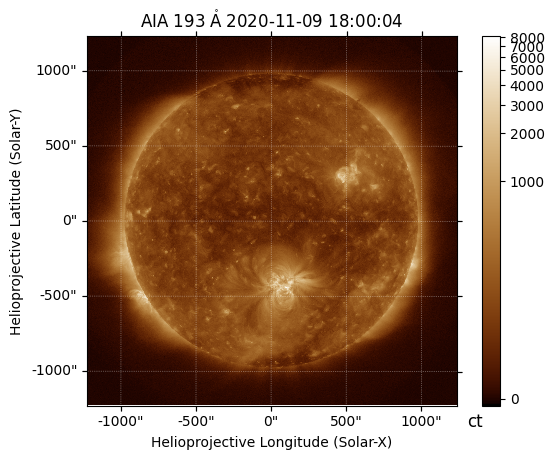

In [93]:
sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_1/aia_193.fits').peek()

In [82]:
q

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2020-11-09 17:59:52.000,2020-11-09 17:59:53.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


In [97]:
smap = sunpy.map.Map('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/2020-11-09T17:59:57_sun_coronal_1992_feldman_ext_all/level_2/aia_171.fits')

In [100]:
wcs_dict = smap.wcs.to_header()

In [103]:
wcs_dict

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                169.5 / Pixel coordinate of reference point            
CRPIX2  =                169.5 / Pixel coordinate of reference point            
CDELT1  =   0.0020555555555556 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0020555555555556 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'           / Coordinate type codegnomonic projection        
CRVAL1  =                  0.0 / [deg] Coordinate value at reference point      
CRVAL2  =                  0.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                  0

In [124]:
temperature = 10**np.arange(5.5, 7.6, 0.1) * u.K

In [136]:
np.log10(temperature.to('eV', equivalencies=u.equivalencies.temperature_energy()).value)

array([1.43537289, 1.53537289, 1.63537289, 1.73537289, 1.83537289,
       1.93537289, 2.03537289, 2.13537289, 2.23537289, 2.33537289,
       2.43537289, 2.53537289, 2.63537289, 2.73537289, 2.83537289,
       2.93537289, 3.03537289, 3.13537289, 3.23537289, 3.33537289,
       3.43537289])

In [151]:
wcs_dict['CTYPE3'] = 'ENER-LOG'
wcs_dict['CRPIX3'] = 1
wcs_dict['CRVAL3'] = 10**1.43537289
wcs_dict['CDELT3'] = 0.1
wcs_dict['CUNIT3'] = 'eV'
test_cube = ndcube.NDCube(np.ones(temperature.shape+smap.data.shape), wcs=astropy.wcs.WCS(wcs_dict))

In [152]:
test_cube.axis_world_coords(0)[0].to('eV')

<SpectralCoord 
   (target: <Helioprojective Coordinate (obstime=2020-11-09T17:59:57.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2020-11-09T17:59:57.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
                (0., 3.42335474, 1.48154618e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, kpc)
                (0., 0., 1000.)
             (d_Tx, d_Ty, d_distance) in (arcsec / s, arcsec / s, km / s)
                (0., 0., 0.)>)
  [27.25039825, 27.35058195, 27.45113397, 27.55205566, 27.65334837,
   27.75501348, 27.85705236, 27.95946637, 28.06225689, 28.16542532,
   28.26897304, 28.37290144, 28.47721192, 28.58190589, 28.68698477,
   28.79244995, 28.89830287, 29.00454494, 29.11117761, 29.2182023 ,
   29.32562046] eV>

In [154]:
np.log10(u.Quantity(test_cube.axis_world_coords(0)[0]).to('K', equivalencies=u.equivalencies.temperature_energy()).value)

array([5.49999996, 5.50159368, 5.5031874 , 5.50478112, 5.50637484,
       5.50796855, 5.50956227, 5.51115599, 5.51274971, 5.51434342,
       5.51593714, 5.51753086, 5.51912458, 5.5207183 , 5.52231201,
       5.52390573, 5.52549945, 5.52709317, 5.52868689, 5.5302806 ,
       5.53187432])

<WCSAxesSubplot:ylabel='Data'>

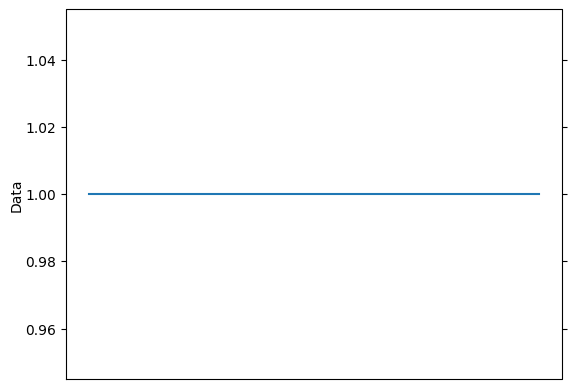

In [118]:
test_cube[:,10,10].plot()